In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib import gridspec
from scipy.stats import norm
#import energyflow as ef

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="0"

# Config

In [86]:
N = 20000
sigma = 1
mu = 0
epsilon = 2

# colors
n_lines = 5
c = np.arange(-3, n_lines + 1)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap="Blues")
cmap.set_array([])

MSE_color = cmap.to_rgba(3)
MSE_darkcolor = cmap.to_rgba(4)
MLC_color = "red"
MLC_darkcolor = "darkred"
data_color = "black"
capsize = 2

In [87]:
gauss_truth_prior = np.random.normal(mu,sigma,N)
gauss_reco_prior = np.random.normal(gauss_truth_prior,epsilon,N)

# MSE

In [88]:
mycalibration = np.polyfit(gauss_reco_prior, gauss_truth_prior, 1)
mypoly = np.poly1d(mycalibration)

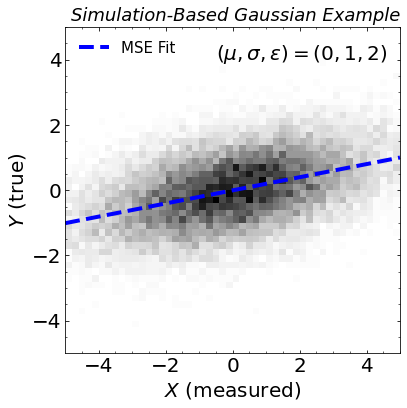

In [91]:
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
plt.subplots_adjust(hspace = .001)

ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

# plt.scatter(gauss_reco_prior,gauss_truth_prior,label="Data",alpha=0.05, color = data_color)
plt.hist2d(gauss_reco_prior,gauss_truth_prior,label="Data", density = True, bins = (50, 50), range = [[-5, 5], [-5, 5]], cmap = "binary")
plt.plot(np.linspace(-5,5,20),mypoly(np.linspace(-5,5,20)),label="MSE Fit",ls="--",color="blue",lw=4)

plt.xlim([-5,5])
plt.ylim([-5,5])
plt.xlabel("$X$ (measured)",fontsize=20)
plt.ylabel("$Y$ (true)",fontsize=20)
leg = plt.legend(frameon=False,fontsize=15,ncol=1, loc = "upper left")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

_=plt.title(r"Simulation-Based Gaussian Example",loc="right",fontsize=18, fontstyle="italic")
_=plt.text(-0.5,4,r"$(\mu,\sigma,\epsilon)=(0,1,2)$",fontsize=20)
plt.savefig("Gaussian_prior.png",bbox_inches='tight',facecolor='white')

In [85]:
np.savetxt("MSE_mu_0_sigma_2.txt",mypoly(np.linspace(-5,5,20)))

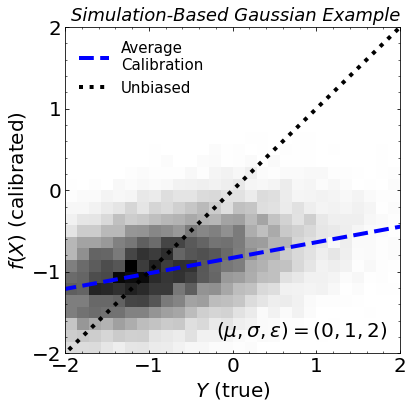

In [9]:
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
plt.subplots_adjust(hspace = .001)

ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

# plt.scatter(gauss_reco_prior,gauss_truth_prior,label="Data",alpha=0.05, color = data_color)
#plt.hist2d(gauss_reco_prior,gauss_truth_prior,label="Data", density = True, bins = (50, 50), range = [[-5, 5], [-5, 5]], cmap = "binary")

plt.hist2d(gauss_truth_prior,mypoly(gauss_reco_prior),label="Calibrated", density = True, bins = (70, 70), range = [[-5, 5], [-5, 5]], cmap = "binary")

#plt.scatter(gauss_truth_prior[0:1000],mypoly(gauss_reco_prior[0:1000]),label="MSE Fit",color="black")

after = np.polyfit(gauss_truth_prior[0:1000], mypoly(gauss_reco_prior[0:1000]), 1)
mypoly_after = np.poly1d(after)

plt.plot(np.linspace(-5,5,20),mypoly_after(np.linspace(-5,5,20)),label="Average\nCalibration",ls="--",color="blue",lw=4)
plt.plot(np.linspace(-5,3.5,20),np.linspace(-5,3.5,20),label="Unbiased",ls=":",color="black",lw=4)

plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel("$Y$ (true)",fontsize=20)
plt.ylabel("$f(X)$ (calibrated)",fontsize=20)
leg = plt.legend(frameon=False,fontsize=15,ncol=1, loc = "upper left")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.locator_params(nbins=4)
_=plt.title(r"Simulation-Based Gaussian Example",loc="right",fontsize=18, fontstyle="italic")
_=plt.text(-0.2,-1.8,r"$(\mu,\sigma,\epsilon)=(0,1,2)$",fontsize=20)
plt.savefig("Gaussian_prior2.pdf",bbox_inches='tight')

# Flow

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from nflows import transforms, distributions, flows
from nflows.utils import torchutils
torch.set_default_dtype(torch.float64)

In [11]:
my_device = torch.device('cpu')

In [12]:
# flow_params_Flow_I = {'num_blocks': 2, #num of layers per block
#                       'features': 1,
#                       'context_features': 1,
#                       'hidden_features': 32,
#                       'use_residual_blocks': False,
#                       'use_batch_norm': False,
#                       'dropout_probability': 0,
#                       'activation':F.relu,
#                       'random_mask': False,
#                       'num_bins': 4,
#                       'tails':'linear',
#                       'tail_bound': 10,
#                       'min_bin_width': 1e-6,
#                       'min_bin_height': 1e-6,
#                       'min_derivative': 1e-6}
flow_params_Flow_I = {'num_blocks': 2, #num of layers per block
                      'features': 1,
                      'context_features': 1,
                      'hidden_features': 64,
                      'use_residual_blocks': False,
                      'use_batch_norm': False,
                      'dropout_probability': 0,
                      'activation':F.relu,
                      'random_mask': False,
                      }
flow_i_blocks = []
for _ in range(1):
    flow_i_blocks.append(transforms.MaskedAffineAutoregressiveTransform(
        **flow_params_Flow_I))
    #flow_i_blocks.append(transforms.RandomPermutation(2))
flow_i_transform = transforms.CompositeTransform(flow_i_blocks)
flow_i_base_distribution = distributions.StandardNormal(shape=[1])
flow_i = flows.Flow(transform=flow_i_transform, distribution=flow_i_base_distribution)

total_parameters = sum(p.numel() for p in flow_i.parameters() if p.requires_grad)

print("Flow I has {} parameters".format(int(total_parameters)))

flow_i.to(my_device)

Flow I has 8706 parameters


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=1, out_features=64, bias=True)
          (context_layer): Linear(in_features=1, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
            (1): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=64, out_features=2, bias=True)
        )
      )
    )
  )
  (_distribution): StandardNormal()
  (_embedding_net): Identity()
)

In [13]:
conds = np.array(gauss_truth_prior).reshape([len(gauss_truth_prior),1])
coords = np.array(gauss_reco_prior).reshape([len(gauss_reco_prior),1])

In [14]:
train_loader = DataLoader(list(zip(coords,conds)), shuffle=True, batch_size=2048)

In [15]:
optimizer = torch.optim.Adam(flow_i.parameters(), lr=1e-4)
best_eval_logprob = float('-inf')
n_epochs = 100
for epoch in range(n_epochs):
    for batch in train_loader:
        flow_i.train()
        optimizer.zero_grad()
        lp = flow_i.log_prob(batch[0].to(my_device), batch[1].to(my_device))
        loss = -lp.mean()
        loss.backward()
        optimizer.step()
        
    output = 'Flow: Evaluate (epoch {}) -- '.format(epoch+1) +\
            'logp(x, at E(x)) = {:.3f}'

    print(output.format(loss))

Flow: Evaluate (epoch 1) -- logp(x, at E(x)) = 2.917
Flow: Evaluate (epoch 2) -- logp(x, at E(x)) = 2.805
Flow: Evaluate (epoch 3) -- logp(x, at E(x)) = 2.802
Flow: Evaluate (epoch 4) -- logp(x, at E(x)) = 2.599
Flow: Evaluate (epoch 5) -- logp(x, at E(x)) = 2.609
Flow: Evaluate (epoch 6) -- logp(x, at E(x)) = 2.562
Flow: Evaluate (epoch 7) -- logp(x, at E(x)) = 2.548
Flow: Evaluate (epoch 8) -- logp(x, at E(x)) = 2.443
Flow: Evaluate (epoch 9) -- logp(x, at E(x)) = 2.362
Flow: Evaluate (epoch 10) -- logp(x, at E(x)) = 2.303
Flow: Evaluate (epoch 11) -- logp(x, at E(x)) = 2.212
Flow: Evaluate (epoch 12) -- logp(x, at E(x)) = 2.212
Flow: Evaluate (epoch 13) -- logp(x, at E(x)) = 2.201
Flow: Evaluate (epoch 14) -- logp(x, at E(x)) = 2.184
Flow: Evaluate (epoch 15) -- logp(x, at E(x)) = 2.158
Flow: Evaluate (epoch 16) -- logp(x, at E(x)) = 2.167
Flow: Evaluate (epoch 17) -- logp(x, at E(x)) = 2.144
Flow: Evaluate (epoch 18) -- logp(x, at E(x)) = 2.163
Flow: Evaluate (epoch 19) -- logp(x, 

In [16]:
from tqdm import tqdm
import einops

In [17]:
# Do MLE: infer the conditional value from (x, y) pairs
n = 20000
flow_i.eval()
mle_xs = np.zeros(n)
for i in tqdm(range(n)):
    coord = torch.from_numpy(coords[i]).float().to(my_device)
    xs = torch.linspace(-5,5,2000).to(my_device).unsqueeze(1)
    coord = einops.repeat(coord, "d -> n d", n=2000)
    lps = flow_i.log_prob(coord.double(), xs.double())
    mle_xs[i] = xs[lps.argmax()]

100%|████████████████████████████████████| 20000/20000 [00:20<00:00, 958.46it/s]


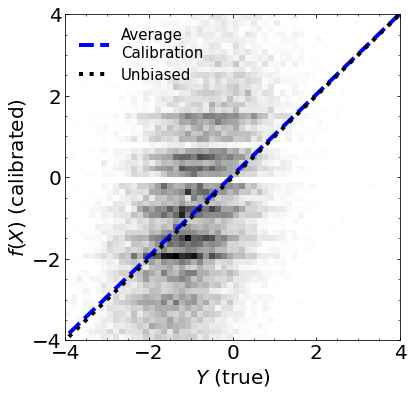

In [18]:
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
plt.subplots_adjust(hspace = .001)

ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()
plt.hist2d(conds[:n].flatten(),mle_xs.flatten(),label="Calibrated", density = True, bins = (70, 70), range = [[-5, 5], [-5, 5]], cmap = "binary")
#plt.scatter(gauss_truth_prior[0:1000],mypoly(gauss_reco_prior[0:1000]),label="MSE Fit",color="black")

after = np.polyfit(conds[:n].flatten(), mle_xs.flatten(), 1)
mypoly_after = np.poly1d(after)

plt.plot(np.linspace(-5,5,20),mypoly_after(np.linspace(-5,5,20)),label="Average\nCalibration",ls="--",color="blue",lw=4)
plt.plot(np.linspace(-5,5,20),np.linspace(-5,5,20),label="Unbiased",ls=":",color="black",lw=4)

plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel("$Y$ (true)",fontsize=20)
plt.ylabel("$f(X)$ (calibrated)",fontsize=20)
leg = plt.legend(frameon=False,fontsize=15,ncol=1, loc = "upper left")
plt.locator_params(nbins=4)

In [20]:
#np.savetxt("mu_neg1_sigma_1.txt",mypoly_after(np.linspace(-5,5,20)))